In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from scipy import stats

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [4]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "futures_dataset_monthly"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    # "naive",
    # "mvo",
    # "bl",
    "linear-ridge",
]

In [5]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [10]:
method = next(iter(portfolio_methods))
dirs = os.listdir(os.path.join(outputs_path, method))
dir = dirs[0]

results = load_pickle(os.path.join(outputs_path, method, dir))

# get forecasts
forecasts = results['forecasts']
forecasts.index = pd.to_datetime(forecasts.index)
forecasts.index.name = "date"

# check which dataframe haas the smallest number of rows and match dates
if len(forecasts) < len(returns):
    returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
else:
    forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

# match columns
forecasts = forecasts[returns.columns]

# portfolio returns
portfolio_returns = forecasts.multiply(returns, axis=0)

In [12]:
forecasts.tail()

,ZG,ZK,ZU,ZB,ZC,ZF,ZT,FN,BN,CN,AN,JN,ES,XU,NK,LX
date,,,,,,,,,,,,,,,,
2023-11-01,0.0,0.336641,0.150606,0.283778,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.108036,0.120939,0.000000
2023-12-01,0.0,0.000000,0.218424,0.000000,0.000000,0.167363,0.240219,0.0,0.0,0.0,0.0,0.0,0.163747,0.000000,0.210246,0.000000
2024-01-01,0.0,0.292914,0.000000,0.000000,0.168631,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.199702,0.189621,0.149131,0.000000
2024-02-01,0.0,0.000000,0.000000,0.000000,0.324862,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.040286,0.069303,0.549234,0.016314
2024-03-01,0.0,0.171741,0.277948,0.305198,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.101200,0.143913,0.000000


<Axes: title={'center': 'Forecasts Sum'}, xlabel='date'>

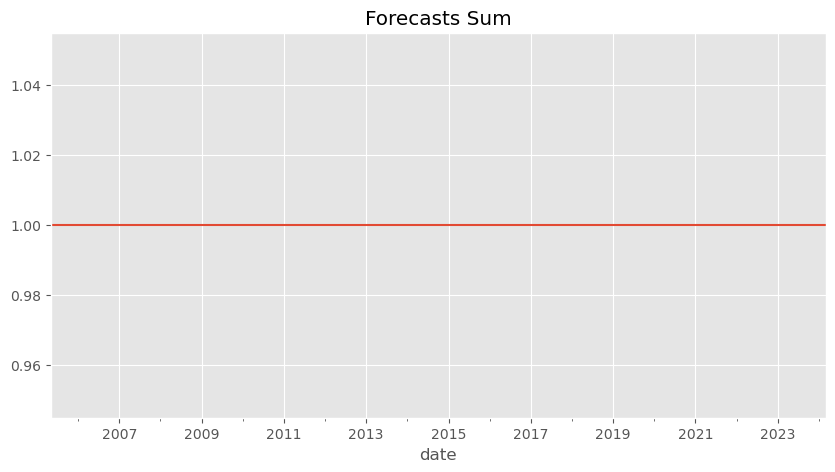

In [19]:
forecasts.sum(axis=1).plot(figsize=(10, 5), title="Forecasts Sum")

<Axes: title={'center': 'Forecasts'}, xlabel='date'>

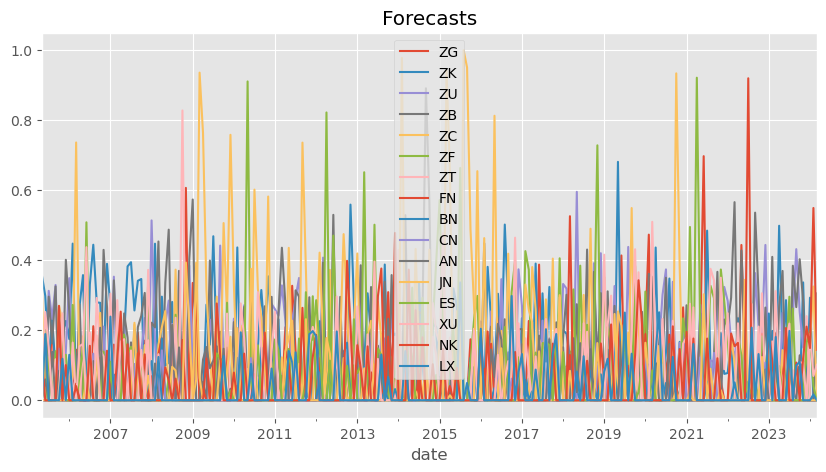

In [21]:
forecasts.plot(figsize=(10, 5), title="Forecasts")

<Axes: xlabel='date'>

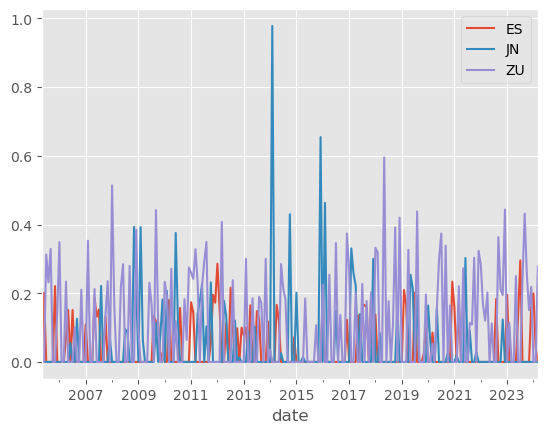

In [23]:
forecasts[['ES', 'JN', 'ZU']].plot()